In [78]:
import os

os.environ["KERAS_BACKEND"] = "torch"
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image, ImageReadMode
import numpy as np
import keras
import random
# from torch.utils.tensorboard import SummaryWriter

SEED = 0
lr = 5e-4
BATCH = 32
EPOCHS = 1

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="max_split_size_mb:1024,max_single_chunk_mb:512,reuse_allow_pool:True,pool_size_mb:2048"
torch.cuda.empty_cache()

In [75]:
class RadioMapDataset(Dataset):
    def __init__(self, data_path, typeOfData, typeOfAntenna='antennas'):
        self.data_path = data_path
        self.typeOfData = typeOfData
        self.typeOfAntenna = typeOfAntenna
        self.list_images = os.listdir(self.data_path + '/' + typeOfData)

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        antenna = '_'.join(self.list_images[idx].split('_')[:2]) + '.png'
        single_signal_path = self.data_path + '/RadioMapSeer/RadioMapSeer/gain/' + 'DPM' + '/' + antenna
        #print("single_sugnakl_path",single_signal_path)
        building = self.data_path + '/RadioMapSeer/RadioMapSeer/png/' + 'buildings_complete' + '/' + f'{self.list_images[idx].split("_")[0]}.png'
        mask = self.data_path + '/' + self.typeOfData + '/' + self.list_images[idx]
        target = self.data_path + '/RadioMapSeer/RadioMapSeer/png/' + self.typeOfAntenna + '/' + antenna

        #print("building",building)
        #print("mask",mask)
        #print("target",target)

        single_signal_image = read_image(single_signal_path, ImageReadMode.GRAY).float()
        mask = read_image(mask, ImageReadMode.GRAY).float()

        target = read_image(target, ImageReadMode.GRAY).float() / 255

        building = read_image(building).float()

        single_signal_image /= 255.0

        building = 0.0 - building / 255.0
        sampling_pixel_img = mask + building
        data = torch.cat([single_signal_image * mask, sampling_pixel_img])
        return data, target

# RadioMapDataset ('path that contain the folder that contains RadioMapDataset', 'name of the sampling rate train image)
# In my case, /home/thanhle/ path has a folder name Downloads that contains RadioMapSeer folder. Full path to RadioMapSeer'/home/thanhle/Downloads/RadioMapSeer/...'
# This can be changed to any folder path. For example, if your full path to folder RadioMapSeer is /home/Doe/RadioMapSeer => then you need to delete the /Downloads/ string in the RadioMapDataset class.
# I would suggest keep the RadioMapSeer in a folder name Downloads for easy. 
# Note: the Train_0_0001_TO_0_001 and Val_0_0001_TO_0_001 should be in the same folder level with the folder that contain RadioMapSeer folder.
# For example, /home/thanhle/ contains Downloads folder that contain RadioMapSeer folder => therefore, the Train_0_0001_TO_0_001 and Val_0_0001_TO_0_001 should be in the /home/thanhle folder.
# /home/thanhle/Train_0_0001_TO_0_001 or /home/thanhle/Val_0_0001_TO_0_001
  
Train = RadioMapDataset("F:/Requirement_files", 'Test_0_0001_TO_0_001/Test_0_0001_TO_0_001')
Val = RadioMapDataset("F:/Requirement_files", 'Val_0_0001_TO_0_001/Val_0_0001_TO_0_001')
Train_Loader = DataLoader(Train, shuffle=True, batch_size=BATCH, drop_last=True)
Val_Loader = DataLoader(Val, shuffle=True, batch_size=BATCH)


In [72]:
x,y=next(iter(Train_Loader))
x.shape,y.shape

(torch.Size([32, 2, 256, 256]), torch.Size([32, 1, 256, 256]))

In [30]:
unique_values = torch.unique(y)

print("Unique values in the tensor:")
print(unique_values)

Unique values in the tensor:
tensor([0., 1.])


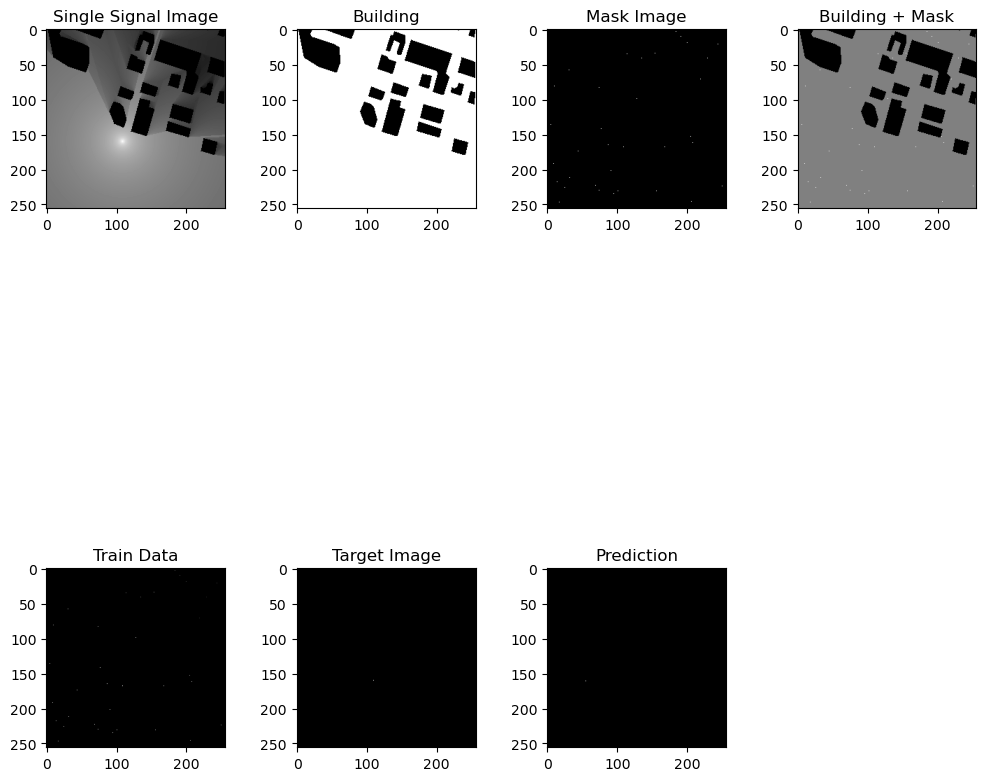

In [38]:
single_signal_path = 'F:/Requirement_files/RadioMapSeer/RadioMapSeer/gain/DPM/103_0.png'
building = 'F:/Requirement_files/RadioMapSeer/RadioMapSeer/png/buildings_complete/103.png'
mask= 'F:/Requirement_files/Test_0_0001_TO_0_001/Test_0_0001_TO_0_001/103_0_3.png'
target= 'F:/Requirement_files/RadioMapSeer/RadioMapSeer/png/antennas/103_0.png'
pred=r"F:\Requirement_files\RadioMapSeer\RadioMapSeer\png\antennas\103_76.png"

single_signal_image = read_image(single_signal_path, ImageReadMode.GRAY).float()
mask = read_image(mask, ImageReadMode.GRAY).float()
target = read_image(target, ImageReadMode.GRAY).float() / 255
building = read_image(building).float()
pred = read_image(pred, ImageReadMode.GRAY).float()

import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the images loaded as tensors

# Convert tensors to numpy arrays
single_signal_image_np = single_signal_image.numpy()
mask_np = mask.numpy()
target_np = target.numpy()
building_np = building.numpy()
pred_np = pred.numpy()

# Plot the images
fig, axs = plt.subplots(2, 4, figsize=(12, 12))

axs[0, 0].imshow(single_signal_image_np[0], cmap='gray')
axs[0, 0].set_title('Single Signal Image')

building_np = 0.0 - building_np[0] / 255.0
axs[0, 1].imshow(building_np, cmap='gray')
axs[0, 1].set_title('Building')

axs[0, 2].imshow(mask_np[0], cmap='gray')
axs[0, 2].set_title('Mask Image')

sampling_pixel_img = mask_np[0] + building_np
axs[0, 3].imshow(sampling_pixel_img, cmap='gray')
axs[0, 3].set_title('Building + Mask')

axs[1, 0].imshow(single_signal_image_np[0] * mask_np[0], cmap='gray')
axs[1, 0].set_title('Train Data')

axs[1, 1].imshow(target_np[0], cmap='gray')
axs[1, 1].set_title('Target Image')

axs[1, 2].imshow(pred_np[0], cmap='gray')
axs[1, 2].set_title('Prediction')

axs[1, 3].set_visible(False)
axs[1, 3].set_visible(False)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Display the plot
plt.show()


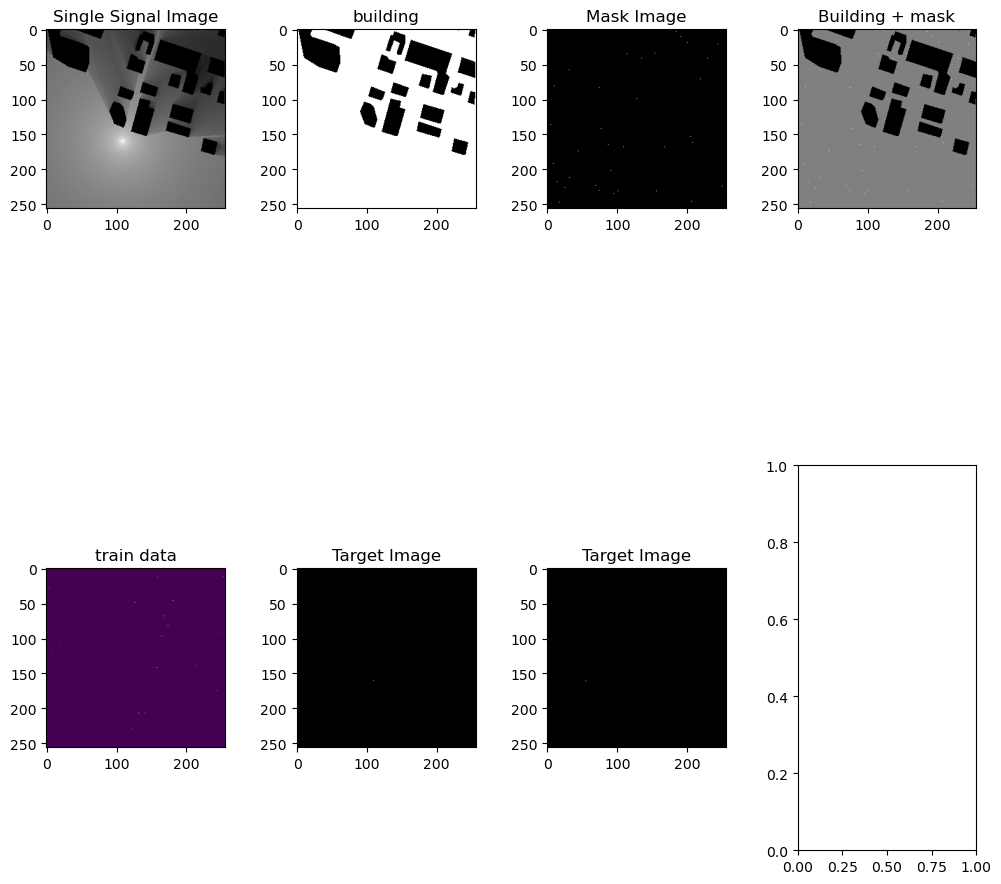

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the images loaded as tensors

# Convert tensors to numpy arrays
single_signal_image_np = single_signal_image.numpy()
mask_np = mask.numpy()
target_np = target.numpy()
building_np = building.numpy()
pred_np= pred.numpy()


# Plot the images
fig, axs = plt.subplots(2, 4, figsize=(12, 12))

axs[0, 0].imshow(single_signal_image_np[0], cmap='gray')
axs[0, 0].set_title('Single Signal Image')

building_np = 0.0 - building_np[0] / 255.0

axs[0, 1].imshow(building_np, cmap='gray')
axs[0, 1].set_title('building')

axs[0, 2].imshow(mask_np[0], cmap='gray')
axs[0, 2].set_title('Mask Image')

sampling_pixel_img = mask_np[0] + building_np

axs[0, 3].imshow(sampling_pixel_img, cmap='gray')
axs[0, 3].set_title('Building + mask')

#data = np.concatenate([single_signal_image_np[0] * mask_np[0], sampling_pixel_img],axis=0)

axs[1, 0].imshow(x[0][0])
axs[1, 0].set_title('train data')

axs[1, 1].imshow(target_np[0], cmap='gray')
axs[1, 1].set_title('Target Image')

axs[1, 2].imshow(pred_np[0], cmap='gray')
axs[1, 2].set_title('Target Image')

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [41]:
data.shape

(512, 256)

Single Sugnakl Image size: (256, 256)
Building Image size: (256, 256)
Mask Image size: (256, 256)
Target Image size: (256, 256)
Single Sugnakl Tensor shape: torch.Size([1, 256, 256])
Building Tensor shape: torch.Size([1, 256, 256])
Mask Tensor shape: torch.Size([1, 256, 256])
Target Tensor shape: torch.Size([1, 256, 256])


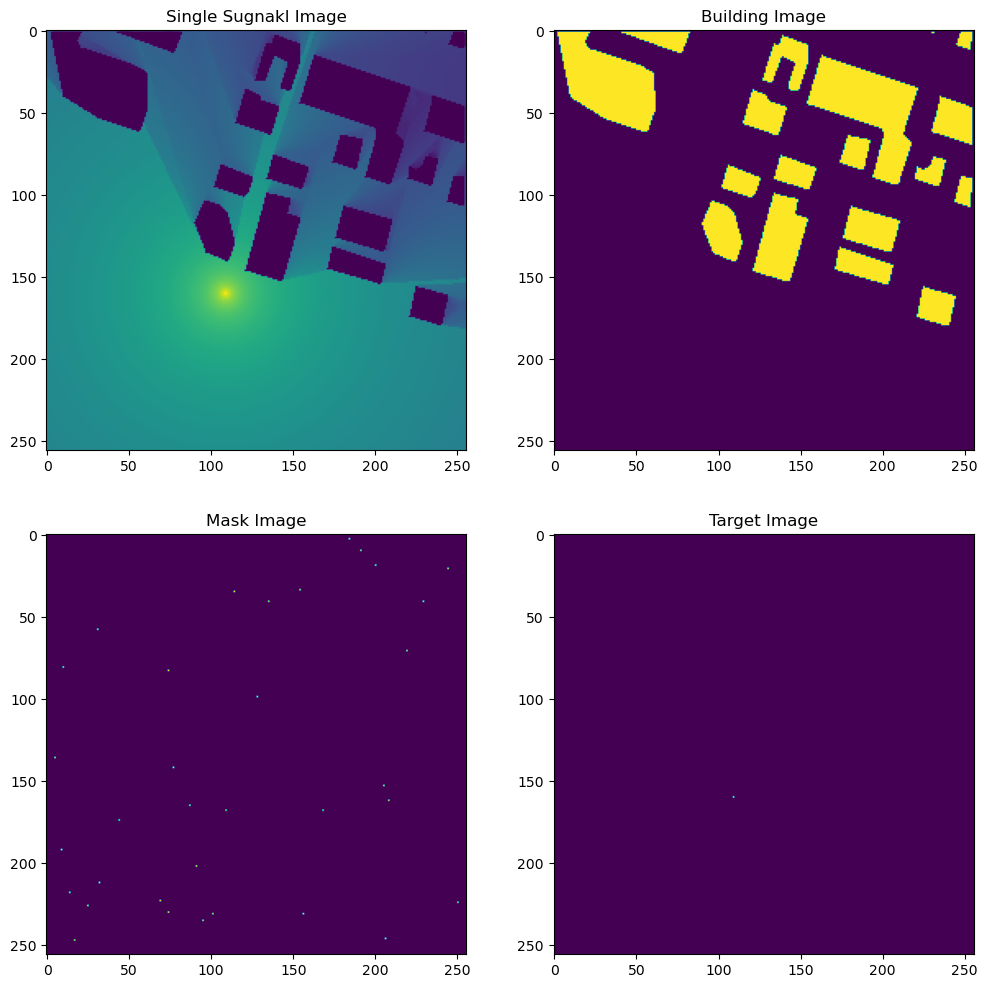

In [25]:
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

# Define the file paths
single_signal_path = 'F:/Requirement_files/RadioMapSeer/RadioMapSeer/gain/DPM/103_0.png'
building_path = 'F:/Requirement_files/RadioMapSeer/RadioMapSeer/png/buildings_complete/103.png'
mask_path = 'F:/Requirement_files/Test_0_0001_TO_0_001/Test_0_0001_TO_0_001/103_0_3.png'
target_path = 'F:/Requirement_files/RadioMapSeer/RadioMapSeer/png/antennas/103_0.png'

# Load the images using PIL
single_sugnakl_img = Image.open(single_sugnakl_path)
building_img = Image.open(building_path)
mask_img = Image.open(mask_path)
target_img = Image.open(target_path)

# Print the image sizes
print(f'Single Sugnakl Image size: {single_sugnakl_img.size}')
print(f'Building Image size: {building_img.size}')
print(f'Mask Image size: {mask_img.size}')
print(f'Target Image size: {target_img.size}')

# Convert the images to tensors
transform = transforms.ToTensor()
single_sugnakl_tensor = transform(single_sugnakl_img)
building_tensor = transform(building_img)
mask_tensor = transform(mask_img)
target_tensor = transform(target_img)

# Print the tensor shapes
print(f'Single Signal Tensor shape: {single_sugnakl_tensor.shape}')
print(f'Building Tensor shape: {building_tensor.shape}')
print(f'Mask Tensor shape: {mask_tensor.shape}')
print(f'Target Tensor shape: {target_tensor.shape}')

# Plot the images
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0, 0].imshow(single_sugnakl_img)
axs[0, 0].set_title('Single Sugnakl Image')
axs[0, 1].imshow(building_img)
axs[0, 1].set_title('Building Image')
axs[1, 0].imshow(mask_img)
axs[1, 0].set_title('Mask Image')
axs[1, 1].imshow(target_img)
axs[1, 1].set_title('Target Image')
plt.show()

In [3]:
cc=next(iter(Train_Loader))

In [11]:
cc[0][0].shape,cc[1][0][0].shape

(torch.Size([2, 256, 256]), torch.Size([256, 256]))

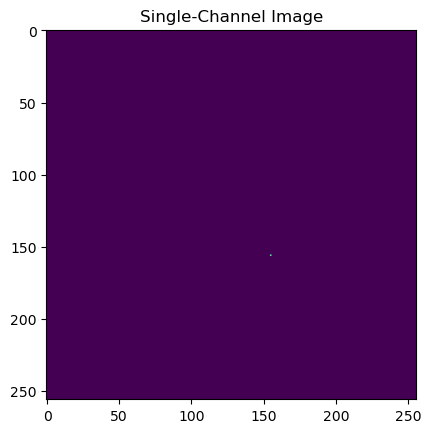

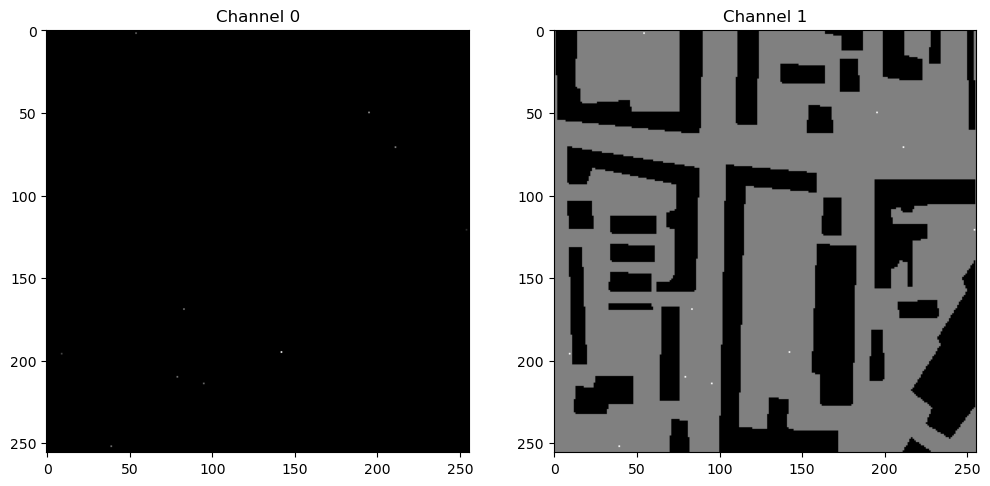

In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the tensor already
tensor = cc[0][0] # Replace with your tensor
tensor1 = cc[1][0][0]  # Replace with your tensor

# Plot the tensor as a grayscale image
plt.imshow(tensor1.numpy())
plt.title("Single-Channel Image")
plt.show()


# Split the tensor into two channels
channel0 = tensor[0].numpy()
channel1 = tensor[1].numpy()

# Plot the two channels as separate grayscale images
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(channel0, cmap='gray')
axs[0].set_title("Channel 0")
axs[1].imshow(channel1, cmap='gray')
axs[1].set_title("Channel 1")
plt.show()

In [4]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=3):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE = torch.nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pred = torch.exp(-1 * BCE) * targets + (1-torch.exp(-1 * BCE)) * (1-targets)
        z = (1 - pred) * targets
        z += (1 - targets) * pred
        z = z ** self.gamma
        alpha = targets * 0.75
        alpha += (1-targets) * 0.25

        return torch.sum(z * BCE * alpha)





In [5]:
class Encoder(nn.Module):
    def __init__(self, enc_in, enc_out, n_dim, leaky_relu_alpha=0.3):
        super(Encoder, self).__init__()

        self.bn_0 = nn.GroupNorm(9, n_dim)
        self.bn_1 = nn.GroupNorm(9, n_dim)
        self.bn_2 = nn.GroupNorm(9, n_dim)
        self.bn_3 = nn.GroupNorm(9, n_dim)
        self.bn_4 = nn.GroupNorm(9, n_dim)
        self.bn_5 = nn.GroupNorm(9, n_dim)
        self.bn_6 = nn.GroupNorm(9, n_dim)
        self.bn_7 = nn.GroupNorm(9, n_dim)
        self.bn_8 = nn.GroupNorm(9, n_dim)
        self.bn_9 = nn.GroupNorm(2, enc_out)

        self.conv2d = nn.Conv2d(enc_in, n_dim, kernel_size=(3, 3), padding='same')
        self.conv2d_1 = nn.Conv2d(n_dim, n_dim, kernel_size=(3, 3), padding='same')
        self.conv2d_2 = nn.Conv2d(n_dim, n_dim, kernel_size=(3, 3), padding='same')
        self.conv2d_3 = nn.Conv2d(n_dim, n_dim, kernel_size=(3, 3), padding='same')
        self.conv2d_4 = nn.Conv2d(n_dim, n_dim, kernel_size=(3, 3), padding='same')
        self.conv2d_5 = nn.Conv2d(n_dim, n_dim, kernel_size=(3, 3), padding='same')
        self.conv2d_6 = nn.Conv2d(n_dim, n_dim, kernel_size=(3, 3), padding='same')
        self.conv2d_7 = nn.Conv2d(n_dim, n_dim, kernel_size=(3, 3), padding='same')
        self.conv2d_8 = nn.Conv2d(n_dim, n_dim, kernel_size=(3, 3), padding='same')
        self.mu = nn.Conv2d(n_dim, enc_out, kernel_size=(3, 3), padding='same')

        self.average_pooling2d = nn.AvgPool2d(kernel_size=(2, 2))
        self.average_pooling2d_1 = nn.AvgPool2d(kernel_size=(2, 2))
        self.average_pooling2d_2 = nn.AvgPool2d(kernel_size=(2, 2))

        self.leaky_relu = torch.nn.LeakyReLU(negative_slope=leaky_relu_alpha)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.leaky_relu(self.bn_0(self.conv2d(x)))
        x = self.leaky_relu(self.bn_1(self.conv2d_1(x)))
        x = self.leaky_relu(self.bn_2(self.conv2d_2(x)))
        skip1 = x
        x = self.average_pooling2d(x)
        x = self.leaky_relu(self.bn_3(self.conv2d_3(x)))
        x = self.leaky_relu(self.bn_4(self.conv2d_4(x)))
        x = self.leaky_relu(self.bn_5(self.conv2d_5(x)))
        skip2 = x
        x = self.average_pooling2d_1(x)
        x = self.leaky_relu(self.bn_6(self.conv2d_6(x)))
        x = self.leaky_relu(self.bn_7(self.conv2d_7(x)))
        x = self.leaky_relu(self.bn_8(self.conv2d_8(x)))
        skip3 = x
        x = self.average_pooling2d_2(x)
        x = self.leaky_relu(self.bn_9(self.mu(x)))
        return x, skip1, skip2, skip3




In [6]:
class Decoder(nn.Module):
    def __init__(self, dec_in, dec_out, n_dim, leaky_relu_alpha=0.3):
        super(Decoder, self).__init__()

        self.bn_0 = nn.GroupNorm(2, dec_in)
        self.bn_1 = nn.GroupNorm(9, n_dim)
        self.bn_2 = nn.GroupNorm(9, n_dim)
        self.bn_3 = nn.GroupNorm(9, n_dim)
        self.bn_4 = nn.GroupNorm(9, n_dim)
        self.bn_5 = nn.GroupNorm(9, n_dim)
        self.bn_6 = nn.GroupNorm(9, n_dim)
        self.bn_7 = nn.GroupNorm(9, n_dim)
        self.bn_8 = nn.GroupNorm(9, n_dim)
        self.bn_9 = nn.GroupNorm(9, n_dim)

        self.conv2d_transpose = nn.ConvTranspose2d(dec_in, dec_in, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2d_transpose_1 = nn.ConvTranspose2d(dec_in + n_dim, n_dim, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2d_transpose_2 = nn.ConvTranspose2d(n_dim, n_dim, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2d_transpose_3 = nn.ConvTranspose2d(n_dim, n_dim, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2d_transpose_4 = nn.ConvTranspose2d(2 * n_dim, n_dim, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2d_transpose_5 = nn.ConvTranspose2d(n_dim, n_dim, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2d_transpose_6 = nn.ConvTranspose2d(n_dim, n_dim, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2d_transpose_7 = nn.ConvTranspose2d(2 * n_dim, n_dim, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2d_transpose_8 = nn.ConvTranspose2d(n_dim, n_dim, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2d_transpose_9 = nn.ConvTranspose2d(n_dim, n_dim, kernel_size=(3, 3), stride=1, padding=1)

        self.up_sampling2d = nn.Upsample(scale_factor=2, mode="bilinear")
        self.up_sampling2d_1 = nn.Upsample(scale_factor=2, mode="bilinear")
        self.up_sampling2d_2 = nn.Upsample(scale_factor=2, mode="bilinear")
        self.dropout = nn.Dropout()
        self.conv2d_output = nn.Conv2d(n_dim, dec_out, kernel_size=(1, 1))

        self.leaky_relu = torch.nn.LeakyReLU(negative_slope=leaky_relu_alpha)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x, skip1, skip2, skip3):
        x = self.leaky_relu(self.bn_0(self.conv2d_transpose(x)))
        x = self.up_sampling2d(x)
        x = torch.cat((x, skip3), dim=1)
        x = self.leaky_relu(self.bn_1(self.conv2d_transpose_1(x)))
        x = self.leaky_relu(self.bn_2(self.conv2d_transpose_2(x)))
        x = self.leaky_relu(self.bn_3(self.conv2d_transpose_3(x)))
        x = self.up_sampling2d_1(x)
        x = torch.cat((x, skip2), dim=1)
        x = self.leaky_relu(self.bn_4(self.conv2d_transpose_4(x)))
        x = self.leaky_relu(self.bn_5(self.conv2d_transpose_5(x)))
        x = self.leaky_relu(self.bn_6(self.conv2d_transpose_6(x)))
        x = self.up_sampling2d_2(x)
        x = torch.cat((x, skip1), dim=1)
        x = self.leaky_relu(self.bn_7(self.conv2d_transpose_7(x)))
        x = self.leaky_relu(self.bn_8(self.conv2d_transpose_8(x)))
        x = self.leaky_relu(self.bn_9(self.conv2d_transpose_9(x)))
        x = self.conv2d_output(x)
        return x




In [7]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = None
        self.decoder = None

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def fit(self, EPOCHS, Train_Loader, Val_Loader, optimizer, loss_fn, start_from_checkpoint=0):
        self.to(self.device)
        save = np.inf
        # writer = SummaryWriter()
        for epoch in range(start_from_checkpoint, EPOCHS):
            n_batches = len(Train_Loader)
            self.train()
            pBar = keras.utils.Progbar(target=n_batches, verbose=1)
            print(f"Starting epoch {epoch + 1}")
            running_loss = 0.0
            for t, data in enumerate(Train_Loader):
                torch.cuda.empty_cache()
                optimizer.zero_grad()
                inputs, targets = data
                inputs, targets = inputs.to(self.device), targets.squeeze().to(self.device)
                preds = self.forward(inputs)
                loss_ = loss_fn(preds.squeeze(), targets)
                loss_.backward()
                optimizer.step()
                running_loss += loss_.item()

                pBar.update(t, values=[("loss", loss_.item())])
            # writer.add_scalar("Loss/Train", running_loss / n_batches, epoch)

            with torch.no_grad():
                dist_loss = 0
                self.eval()
                for inputs, targets in Val_Loader:
                    self.eval()
                    inputs = inputs.to('cuda')
                    preds = torch.nn.Sigmoid()(model.forward(inputs)).squeeze().detach().cpu()
                    targets = targets.squeeze()
                    peak_points = torch.amax(preds, dim=(1, 2))
                    peak_points = torch.unsqueeze(torch.unsqueeze(peak_points, dim=1), dim=1)
                    z_coord, row_coord, col_coord = torch.where(preds == peak_points)
                    masked_coord = torch.arange(0, len(z_coord))

                    masked_indices = torch.zeros((len(torch.unique(z_coord)),),
                                                 dtype=z_coord.dtype).scatter_(0,
                                                                               z_coord,
                                                                               masked_coord)
                    masked_row = torch.unsqueeze(row_coord[masked_indices], dim=1)
                    masked_col = torch.unsqueeze(col_coord[masked_indices], dim=1)
                    preds = torch.cat([masked_row, masked_col], dim=1)

                    target_peak_points = torch.unsqueeze(torch.unsqueeze(torch.amax(targets, dim=(1, 2)), dim=1), dim=1)
                    batch_target, row_target, col_target = torch.where(targets == target_peak_points)

                    target_row = torch.unsqueeze(row_target, dim=1)
                    target_col = torch.unsqueeze(col_target, dim=1)
                    targets = torch.cat([target_row, target_col], dim=1)
                    euclidean_dist_no_reduction = torch.sqrt(torch.sum((preds - targets) ** 2, dim=1))
                    dist_loss += torch.sum(euclidean_dist_no_reduction)

            # writer.add_scalar("Dist_Loss/Eval", dist_loss / 40000, epoch)
            pBar.update(n_batches, values=[("error_dist_sum_losses", dist_loss)])
            if dist_loss <= save:
                save = dist_loss
                # Name of the folder
                self.save_model(optimizer=optimizer, filename=f'LocNet_3_75_{epoch + 1}.pt')
        # writer.flush()
        # writer.close()

    def save_model(self, optimizer, filename):
        torch.save({
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        },
            self.outpath + filename)




In [8]:
class SkipAutoencoder(Autoencoder):
    def __init__(self, outpath, enc_in=2, enc_out=4, dec_out=1, n_dim=4, leaky_relu=0.3):
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.outpath = outpath
        self.encoder = Encoder(enc_in, enc_out, n_dim, leaky_relu_alpha=leaky_relu)
        self.decoder = Decoder(enc_out, dec_out, n_dim, leaky_relu_alpha=leaky_relu)

    def forward(self, x):
        x, skip1, skip2, skip3 = self.encoder(x)
        x = self.decoder(x, skip1, skip2, skip3)
        torch.cuda.empty_cache()
        return x




In [64]:
model = SkipAutoencoder(enc_in=2,
                        enc_out=4,
                        dec_out=1,
                        n_dim=27,
                        leaky_relu=0.3,
                        outpath=r"F:\Requirement_files")
model.to(device)



SkipAutoencoder(
  (encoder): Encoder(
    (bn_0): GroupNorm(9, 27, eps=1e-05, affine=True)
    (bn_1): GroupNorm(9, 27, eps=1e-05, affine=True)
    (bn_2): GroupNorm(9, 27, eps=1e-05, affine=True)
    (bn_3): GroupNorm(9, 27, eps=1e-05, affine=True)
    (bn_4): GroupNorm(9, 27, eps=1e-05, affine=True)
    (bn_5): GroupNorm(9, 27, eps=1e-05, affine=True)
    (bn_6): GroupNorm(9, 27, eps=1e-05, affine=True)
    (bn_7): GroupNorm(9, 27, eps=1e-05, affine=True)
    (bn_8): GroupNorm(9, 27, eps=1e-05, affine=True)
    (bn_9): GroupNorm(2, 4, eps=1e-05, affine=True)
    (conv2d): Conv2d(2, 27, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2d_1): Conv2d(27, 27, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2d_2): Conv2d(27, 27, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2d_3): Conv2d(27, 27, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2d_4): Conv2d(27, 27, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2d_5): Conv2d(27, 27, kern

In [65]:
model_state_dict = torch.load(r"F:\Requirement_files\Inference_code_with_weights_with_Bucket_dataset\UNET_CONSTANT_3_ALPHA_75_0_0001_VERSION_2_98.pt")


# Load the state dictionary into the model
model.load_state_dict(model_state_dict)

# Now you can call model.eval()


<All keys matched successfully>

In [66]:
model.eval()

SkipAutoencoder(
  (encoder): Encoder(
    (bn_0): GroupNorm(9, 27, eps=1e-05, affine=True)
    (bn_1): GroupNorm(9, 27, eps=1e-05, affine=True)
    (bn_2): GroupNorm(9, 27, eps=1e-05, affine=True)
    (bn_3): GroupNorm(9, 27, eps=1e-05, affine=True)
    (bn_4): GroupNorm(9, 27, eps=1e-05, affine=True)
    (bn_5): GroupNorm(9, 27, eps=1e-05, affine=True)
    (bn_6): GroupNorm(9, 27, eps=1e-05, affine=True)
    (bn_7): GroupNorm(9, 27, eps=1e-05, affine=True)
    (bn_8): GroupNorm(9, 27, eps=1e-05, affine=True)
    (bn_9): GroupNorm(2, 4, eps=1e-05, affine=True)
    (conv2d): Conv2d(2, 27, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2d_1): Conv2d(27, 27, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2d_2): Conv2d(27, 27, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2d_3): Conv2d(27, 27, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2d_4): Conv2d(27, 27, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2d_5): Conv2d(27, 27, kern

In [77]:
export PYTORCH_CUDA_ALLOC_CONF="max_split_size_mb:1024,max_single_chunk_mb:512,reuse_allow_pool:True,pool_size_mb:2048"

SyntaxError: invalid syntax (3709829305.py, line 1)

In [67]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [79]:
# Create a list to store the predictions
predictions = []

# Iterate over the test dataset
with torch.no_grad():
    for batch in Val_Loader:
        # Get the input and target tensors
        input_tensor, target_tensor = batch

        # Move the tensors to the device (e.g., GPU)
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        # Forward pass
        output = model(input_tensor)
        print(output.shape)

        # Append the predictions to the list
        predictions.extend(output)

OutOfMemoryError: CUDA out of memory. Tried to allocate 216.00 MiB. GPU 0 has a total capacty of 4.00 GiB of which 110.35 MiB is free. Of the allocated memory 2.48 GiB is allocated by PyTorch, and 23.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [58]:
torch.cuda.memory_cache=True

In [48]:
torch.cuda.empty_cache()

In [54]:
print(torch.cuda.memory_reserved())

2092957696


In [55]:
print(torch.cuda.memory_allocated())

2087806976


In [51]:
print(torch.cuda.max_memory_allocated())

2020698112


In [46]:
torch.cuda.reset_peak_memory_stats()

In [56]:
torch.cuda.memory_snapshot()

[{'device': 0,
  'address': 30098325504,
  'total_size': 2097152,
  'allocated_size': 533504,
  'active_size': 533504,
  'requested_size': 510728,
  'stream': 0,
  'segment_type': 'small',
  'segment_pool_id': (0, 0),
  'is_expandable': False,
  'frames': [],
  'blocks': [{'address': 30098325504,
    'size': 105984,
    'requested_size': 864,
    'state': 'inactive',
    'frames': []},
   {'address': 30098431488,
    'size': 26624,
    'requested_size': 26244,
    'state': 'active_allocated',
    'frames': []},
   {'address': 30098458112,
    'size': 26624,
    'requested_size': 26244,
    'state': 'active_allocated',
    'frames': []},
   {'address': 30098484736,
    'size': 26624,
    'requested_size': 26244,
    'state': 'active_allocated',
    'frames': []},
   {'address': 30098511360,
    'size': 512,
    'requested_size': 108,
    'state': 'active_allocated',
    'frames': []},
   {'address': 30098511872,
    'size': 26624,
    'requested_size': 26244,
    'state': 'active_alloca